In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [4]:
picture_size = 32
folder_path = "images/"
batch_size = 32
epochs = 100
no_of_classes = 6

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from collections import Counter
import random

def preprocess_images(folder_path, picture_size, color_mode='grayscale', balance_dataset=True):
    print(f"Preprocessing images in: {folder_path}")
    
    if not os.path.exists(folder_path):
        print(f"Error: The path {folder_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Contents of current directory: {os.listdir('.')}")
        raise FileNotFoundError(f"The path {folder_path} does not exist")
    
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    
    print(f"Found the following classes: {class_names}")
    
    class_counts = Counter()
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    
    print(f"Image counts per class: {dict(class_counts)}")
    
    if balance_dataset:
        min_count = min(class_counts.values())
        print(f"Balancing dataset. Each class will have {min_count} images.")
    else:
        min_count = max(class_counts.values()) 
    
    total_images = min_count * len(class_names)
    pbar = tqdm(total=total_images, desc="Processing images")
    
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        class_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        if balance_dataset:
            class_images = random.sample(class_images, min_count)
        
        for img_name in class_images[:min_count]:  # Limit to min_count
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(picture_size, picture_size), color_mode=color_mode)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_name)
            pbar.update(1)
    
    pbar.close()
    
    print("Converting to numpy array and normalizing...")
    images = np.array(images, dtype='float32') / 255.0
    
    print("Encoding labels...")
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded)
    
    return images, labels_categorical, le.classes_


folder_path = "images"
picture_size = 32
train_path = os.path.join(folder_path, "train")
X_train, y_train, class_names = preprocess_images(train_path, picture_size, balance_dataset=True)
val_path = os.path.join(folder_path, "validation")
X_val, y_val, _ = preprocess_images(val_path, picture_size, balance_dataset=True)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Preprocessing images in: images\train
Found the following classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Image counts per class: {'angry': 3993, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}
Balancing dataset. Each class will have 3205 images.


Processing images: 100%|██████████| 19230/19230 [03:07<00:00, 102.65it/s]


Converting to numpy array and normalizing...
Encoding labels...
Preprocessing images in: images\validation
Found the following classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Image counts per class: {'angry': 960, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Balancing dataset. Each class will have 797 images.


Processing images: 100%|██████████| 4782/4782 [00:55<00:00, 86.77it/s] 

Converting to numpy array and normalizing...
Encoding labels...
Training data shape: (19230, 32, 32, 1)
Training labels shape: (19230, 6)
Validation data shape: (4782, 32, 32, 1)
Validation labels shape: (4782, 6)
Number of classes: 6
Class names: ['angry' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_improved_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        
        Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),
        
        Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
        
        Flatten(),
        Dense(256, kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = create_improved_model(input_shape, num_classes)



C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=32,  
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.2267 - loss: 2.1357 - val_accuracy: 0.2482 - val_loss: 1.9222 - learning_rate: 0.0010
Epoch 2/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.3186 - loss: 1.7273 - val_accuracy: 0.3430 - val_loss: 1.7256 - learning_rate: 0.0010
Epoch 3/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3722 - loss: 1.6193 - val_accuracy: 0.4262 - val_loss: 1.5206 - learning_rate: 0.0010
Epoch 4/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.4009 - loss: 1.5691 - val_accuracy: 0.4448 - val_loss: 1.4812 - learning_rate: 0.0010
Epoch 5/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.4250 - loss: 1.5325 - val_accuracy: 0.4571 - val_loss: 1.4868 - learning_rate: 0.0010
Epoch 6/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.4415 - loss: 1.5042 - val_accuracy: 0.4573 - val_loss: 1.4836 - learning_rate: 0.0010
Epoch 7/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4

601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5723 - loss: 1.1925 - val_accuracy: 0.5546 - val_loss: 1.2447 - learning_rate: 4.0000e-05
Epoch 44/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5719 - loss: 1.2015 - val_accuracy: 0.5590 - val_loss: 1.2329 - learning_rate: 4.0000e-05


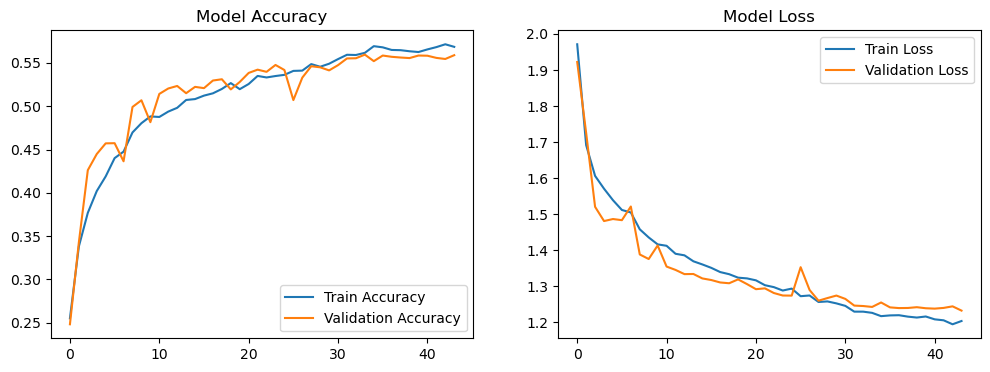

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [11]:
model_2 = create_improved_model(input_shape, num_classes)

C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  
    batch_size=32,  
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.3319 - loss: 1.7122 - val_accuracy: 0.3821 - val_loss: 1.5934 - learning_rate: 2.0000e-04
Epoch 2/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3668 - loss: 1.6462 - val_accuracy: 0.3760 - val_loss: 1.6057 - learning_rate: 2.0000e-04
Epoch 3/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3841 - loss: 1.6001 - val_accuracy: 0.3810 - val_loss: 1.6217 - learning_rate: 2.0000e-04
Epoch 4/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.3939 - loss: 1.5787 - val_accuracy: 0.4285 - val_loss: 1.4973 - learning_rate: 2.0000e-04
Epoch 5/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.4078 - loss: 1.5527 - val_accuracy: 0.3846 - val_loss: 1.5918 - learning_rate: 2.0000e-04
Epoch 6/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.4151 - loss: 1.5266 - val_accuracy: 0.4235 - val_loss: 1.5157 - learning_rate: 2.0000e-04
Epoch 7/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 2